In [1]:
import matplotlib.pyplot as plt
import os

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
import torch

torch.Size([13, 2, 1])
torch.Size([2])


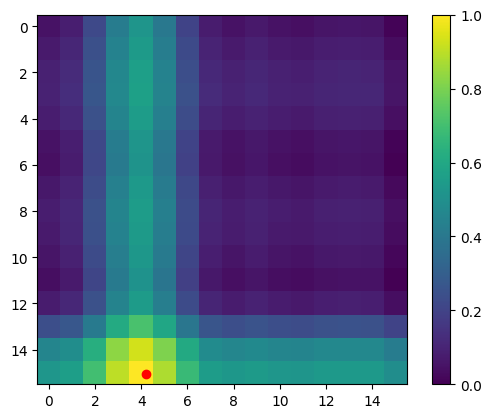

In [2]:
rescale = 2
x = torch.rand((13,2)).unsqueeze(-1)*rescale
B = torch.randn((2, 100))
# [13,2,60]
projected = (2 * torch.pi * x) * B
# [13,2,120]
projected = projected.flatten(start_dim=-2)
# [13,2,240]
x_proj = torch.cat([torch.sin(projected), torch.cos(projected)], dim=-1)

coords = torch.arange(.5,16)/16*rescale
ii,jj = torch.meshgrid(coords,coords, indexing = 'xy')
coords = torch.stack([ii,jj], dim = -1)
coords = coords.unsqueeze(-1)
coords.shape
projected = (2 * torch.pi * coords) * B
# [13,120]
projected = projected.flatten(start_dim=-2)
# [13,240]
img_proj = torch.cat([torch.sin(projected), torch.cos(projected)], dim=-1)
sim = img_proj@x_proj.transpose(0,1)

idx = torch.randint(0,13,(1,))[0]
print(x.shape)
item_coords = (x[idx,:,0]*16 - 0.5)/rescale
print(item_coords.shape)
plt.scatter(item_coords[0], item_coords[1], color = 'red')
plt.colorbar()
plt.imshow(sim[:,:,idx])


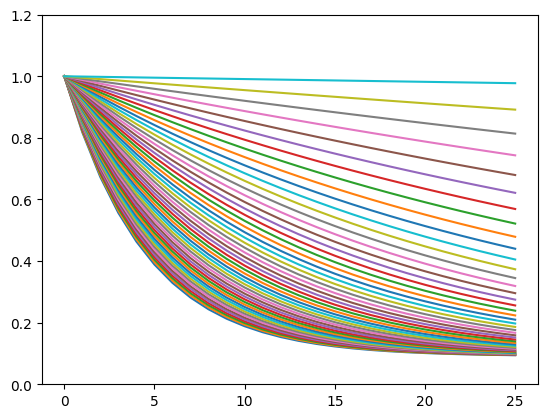

In [27]:
x = torch.arange(26)
b = 0.8
plt.ylim(0, 1.2)
b = torch.linspace(0.8,0.999,50)
alpha = 10
for i in range(50):
    y = (alpha* (b[i]**x) + 1)/(1 + alpha)
    plt.plot(x,y)
plt.show()